# Capstone Project - Car Accident Severity

## Introduction
Car accidents, or in general traffic accidents are a serious problem of the modern society. The World Health Organisation estimates that very year, road accidents result in more than 1.3 million deaths, 20 to 50 million of non-fatal injuries and costs economies 3% of their annual gross domestic product through lost resources, productivity and collateral damage. It is thus important to determine the factors leading to accidents, in order to develop strategies to eliminate or mitigate them to reduce the occurrences  of traffic accidents.

Traffic accidents lead to a variety of consequences, ranging from altercations, minor property damages to the more severe loss of human lives. Having studied the factors causing traffic accidents, a subsequent, important step is to then determine **what affects the level of severity of accidents, and if we can effectively predict the severity of the accidents**.

### Problem
Aside from understanding the factors causing accidents, it is also imperative to **understand what causes severe accidents** so that we can predict them and developed targeted, prioritised strategies to reduce high severity accident occurrences  first, as an efficient use of limited resources. 

### Interest
With such insights, country agencies can efficiently allocate resources to reduce high severity accidents by eliminating mitigatable factors (e.g. improving lighting conditions at specific junctions) and ameliorate  the consequences of un-mitigatable accidents (e.g. deploy more medical/evacuation personnel at regions where and/or periods during which high severity accidents are likely to occur to increase survivability of those involved).


## Data Acquisition & Understanding
### Data Source
In order to answer the question on which factors affect the severity of accidents, the data should include information/attributes on the weather conditions, location, number and types of parties involved, other event factors and preferably the labelled data attribute of accident severity.

Luckily, a convenient data source has been kindly provided by the course instructors [here](https://www.coursera.org/learn/applied-data-science-capstone/supplement/Nh5uS/downloading-example-dataset). Metadata of the dataset can be found [here](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf).

### Data Description
The provided dataset contains 194,673 entries (rows), with 38 different features (columns). Each entry contains information regarding an accident incident, generally including information on:

* **Severity of the accident**
   * This includes severity class/code, severity description  
* **Location of the accident**
   * This includes (X, y) coordinates, address, location type, junction type
* **Date-Time of the accident**
   * This includes the date and the time
* **Environment conditions**
   * This includes the weather, road surface conditions, lighting conditions
* **Parties involved**
   * This includes the number of pedestrians, vehicles, cyclists involved
* **Event information**
   * This includes information on the type of collision, the description of the collision and if the vehicle was speeding

A snapshot of the dataset is shown below.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# libraries for downloading csv file
import csv
import requests

# libraries for visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# libraries from sklearn
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# libraries for data resampling
# conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# # url of file - download file. comment out if not needed
url = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'

# download csv dataset onto local directory
with requests.get(url, stream=True) as response:
    response.raise_for_status()

    with open("Data_collisions.csv", "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
        file.flush()

In [3]:
# load as pandas dataframe
df = pd.read_csv('Data_collisions.csv')
df.head(3)

C:\Users\marti\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N


In [4]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

### Initial Feature Selection
The main targeted feature would be the *SEVERITYCODE*, which represents the two possible state/class of the accidents - (1) Property damage only, (2) Injury. Given that this is a binary classification problem, we will explore the use of Logistic Regression (LR) and the ensemble Random Forest Classification (RF) models. Gradient Boosting Classifiers (GBC) which were found to normally provide superior results for binary and multi-class classification tasks will also be used.

The table below shows a list of features that will be dropped and those that will be used in the subsequent Exploratory Data Analysis (EDA) and feature engineering:

| Feature Categories | Features to keep | Features to drop |
| -------------------|------------------|------------------|
| Severity of incident |SEVERITYCODE | SEVERITYDESC|
| Junction & location | ADDRTYPE, JUNCTIONTYPE, CROSSWALKKEY, SEGLANEKEY | INTKEY, X, Y, LOCATION |
| Date Time | INCDATE, INCDTTM | - |
| Parties Involved | PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, WEATHER, ROADCOND, LIGHTCOND, HITPARKEDCAR| - |
| Event Information | - |ST_COLCODE, ST_COLDESC, COLLISIONTYPE, SDOT_COLCODE, SDOT_COLDESC, SDOTCOLNUM, SPEEDING, INATTENTIONIND |
| Others | STATUS | OBJECTID, INCKEY, COLDETKEY, REPORTNO, UNDERINFL, PEDROWNOTGRNT, EXCEPTRSNCODE, EXCEPTRSNDESC |

#### Severity

There are several redundant features found in the dataset. For example, *SEVERITYDESC* describes the type of severity, either as "injury collision" or "property damage only" and this is similar to the information *SEVERITYCODE* presents. It is necessary to remove *SEVERITYDESC* or we run the risk of causing target leakage. 

*SEVERITYCODE* will be kept as a feature.

In [5]:
df.groupby('SEVERITYCODE')['SEVERITYDESC'].value_counts()

SEVERITYCODE  SEVERITYDESC                  
1             Property Damage Only Collision    136485
2             Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

#### Junction & Location

Further redundancies include *INTKEY* which corresponds to the specific collision intersection (with 7615 unique values). Using this information may result in overfitting due to high specificity. Instead, *ADDRTYPE*, which classifies the collision address into 3 general classes is a much better feature to use.

In [6]:
# exploring INTKEY unique values and counts
print(np.sort(df['INTKEY'].unique()))
print(len(df['INTKEY'].unique()))

[ 23807.  23808.  23811. ... 725404. 757580.     nan]
7615


Another feature *JUNCTIONTYPE* also presents information regarding the category of the junction where the accidents occur. A closer inspection of the values reveal that it can adds a layer of dimension to *ADDRTYPE* as it contains information on whether the accident is related to a junction or not, i.e. the address can be a non-junction, but still be junction related.

As such, *JUNCTIONTYPE* and *ADDRTYPE* would be retained as features.

In [7]:
# exploring junctiontype and addrtype relationship
df.groupby('ADDRTYPE')['JUNCTIONTYPE'].value_counts()

ADDRTYPE      JUNCTIONTYPE                                     
Alley         Mid-Block (not related to intersection)                176
              Driveway Junction                                       59
              At Intersection (but not related to intersection)        1
Block         Mid-Block (not related to intersection)              89330
              Mid-Block (but intersection related)                 22774
              Driveway Junction                                    10611
              Ramp Junction                                          133
              At Intersection (intersection related)                   4
              Unknown                                                  4
              At Intersection (but not related to intersection)        1
Intersection  At Intersection (intersection related)               62782
              At Intersection (but not related to intersection)     2094
              Ramp Junction                                 

*CROSSWALKKEY* could also be used to indicate if the accident involves a crosswalk, encoding could be used to label rows with valid crosswalk keys (non-zero values) and those without (zero values).

Predominantly, most incidents (190,862 out of the 194,673 entries) do not involve a crosswalk. *CROSSWALKKEY* will be kept as a feature.


In [8]:
# exploring crosswalkkey value counts
df['CROSSWALKKEY'].value_counts()

0         190862
523609        17
520838        15
525567        13
521707        10
           ...  
521019         1
630862         1
25545          1
523322         1
27186          1
Name: CROSSWALKKEY, Length: 2198, dtype: int64

               NON_ZERO_CROSSWALKKEY_COUNT  ZERO_CROSSWALKKEY_COUNT
COLLISIONTYPE                                                      
Angles                                   8                    34666
Cycles                                 627                     4788
Left Turn                                5                    13698
Other                                    4                    23699
Parked Car                               1                    47986
Pedestrian                            3104                     3504
Rear Ended                              10                    34080
Right Turn                               2                     2954
Sideswipe                                2                    18607


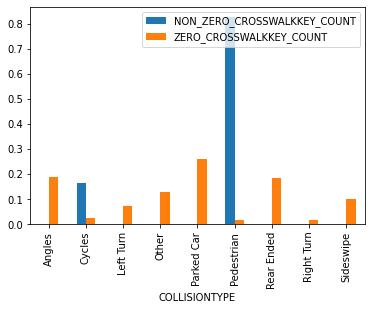

In [9]:
# filtering out CROSSWALKKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['CROSSWALKKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_CROSSWALKKEY_COUNT')
del_df2 = df[df['CROSSWALKKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_CROSSWALKKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')

plt.show()

*SEGLANEKEY* has a similar pattern and indicates the key for the lane segment where the accident occurred. By plotting the normalised value counts of the non-zero vs zero *SEGLANEKEY* entries according to their corresponding *COLLISIONTYPE*, we see that a non-zero *SEGLANEKEY* largely corresponds to involving cycles.

However, note that this does not neccessarily mean that zero *SEGLANEKEY* does not lead to collisions involving cycles as seen by the almost similar counts (2,668 vs 2,747). *SEGLANEKEY* will be kept as a feature.

In [10]:
# exploring SEGLANEKEY values
df['SEGLANEKEY'].value_counts()

0         191907
6532          19
6078          16
12162         15
10336         14
           ...  
35157          1
10817          1
15043          1
525169         1
16376          1
Name: SEGLANEKEY, Length: 1955, dtype: int64

               NON_ZERO_SEGLANEKEY_COUNT  ZERO_SEGLANEKEY_COUNT
COLLISIONTYPE                                                  
Angles                                 9                  34665
Cycles                              2668                   2747
Head On                                2                   2022
Left Turn                             14                  13689
Other                                 19                  23684
Parked Car                             2                  47985
Pedestrian                             4                   6604
Rear Ended                             4                  34086
Right Turn                             4                   2952
Sideswipe                              4                  18605


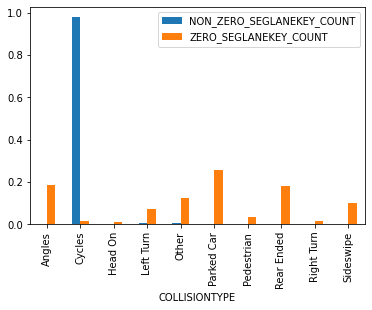

In [11]:
# filtering out SEGLANEKEY according to non-zero and zero values, grouped by COLLISIONTYPE
del_df1 = df[df['SEGLANEKEY'] !=0].groupby('COLLISIONTYPE').size().to_frame('NON_ZERO_SEGLANEKEY_COUNT')
del_df2 = df[df['SEGLANEKEY'] ==0].groupby('COLLISIONTYPE').size().to_frame('ZERO_SEGLANEKEY_COUNT')

# merging 2 dfs and normalising along columns
del_df1 = pd.merge(del_df1, del_df2, on='COLLISIONTYPE')
print(del_df1)
del_df1 = (del_df1/del_df1.sum()).reset_index()

# plot 
del_df1.plot(x='COLLISIONTYPE', kind='bar')
plt.show()

Regarding location features in the dataset which includes *X, Y, LOCATION*, while these are useful to identify certain specific hotspot location, they do not present general information about the location features, i.e. we are unable to decipher the features that may be of importance such as curvature, inclination, speed limits of the roads at the specific location. It is not recommended to use these features without further feature engineering.

#### Date-Time
*INCDATE, INCDTTM* contains the datetime information of the incident and are relevant.

#### Environmental Conditions
*WEATHER, ROADCOND, LIGHTCOND* which represents the environmental conditions surrounding the accident event are relevant.

#### Parties Involved
Other relevant features would include *PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT* which provides information on the number of different parties involved in the accident and are thus highly relevant. They indicate if cyclists, pedestrians and/or vehicles are involved.

The *HITPARKEDCAR* feature is an interesting feature which presents information on whether a parked vehicle was involved in the accident or not. We would include this feature for further analysis on relevancy.

#### Event Information
*ST_COLCODE, ST_COLDESC, COLLISIONTYPE, SDOT_COLCODE, SDOT_COLDESC, SDOTCOLNUM* features contain information about the collision event, i.e. how the accidents occur, whether it involves rear-ending, accident at an angle etc. While these are useful, they are information that are generated after the accident has occurred by SDOT and are not readily and reliably available before and during the collision, they are thus removed.

The *SPEEDING* feature presents information on whether speeding (i.e. speed above a stipulated speed limit) was a factor of the collision or not. This feature is surprisingly not very useful as it does not indicate how much above what speed limit (so that a change to the speed limit may be prescribed), nor how this classification was derived. It may have been subjectively derived by SDOT (e.g. if speeding happened, but SDOT did not judge it to be a factor). The *INATTENTIONIND* feature has similar attributes and thus would also not be included.

#### Others
Features *OBJECTID, INCKEY, COLDETKEY, REPORTNO* can also be removed as the contain keys and identification numbers which does not provide further information currently. *EXCEPTRSNCODE, EXCEPTRSNDESC* can be dropped.

Feature *STATUS can be used be used to clean the data.

For *UNDERINFL, PEDROWNOTGRNT*, these features are related to laws that have been broken in the event of the accident. Given that these are traffic laws which are already enforced and should continue to be strongly enforced, these will not be of interest to the current study.

In [12]:
# list of features to keep

features = ['STATUS','ADDRTYPE', 'SEVERITYCODE','PERSONCOUNT', 'PEDCOUNT',
            'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'INCDTTM','JUNCTIONTYPE',
            'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEGLANEKEY','CROSSWALKKEY',
            'HITPARKEDCAR']

## Data Cleaning

In [13]:
# create dataframe with features
df1 = df[features]

# lowercase all column header for easier manipulation
df1.columns = df1.columns.str.lower()

df1.head(3)

,status,addrtype,severitycode,personcount,pedcount,pedcylcount,vehcount,incdate,incdttm,junctiontype,weather,roadcond,lightcond,seglanekey,crosswalkkey,hitparkedcar
0,Matched,Intersection,2,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),Overcast,Wet,Daylight,0,0,N
1,Matched,Block,1,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,0,0,N
2,Matched,Block,1,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),Overcast,Dry,Daylight,0,0,N


In [14]:
# basic exploration of datatypes and null-values in df1
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 16 columns):
status          194673 non-null object
addrtype        192747 non-null object
severitycode    194673 non-null int64
personcount     194673 non-null int64
pedcount        194673 non-null int64
pedcylcount     194673 non-null int64
vehcount        194673 non-null int64
incdate         194673 non-null object
incdttm         194673 non-null object
junctiontype    188344 non-null object
weather         189592 non-null object
roadcond        189661 non-null object
lightcond       189503 non-null object
seglanekey      194673 non-null int64
crosswalkkey    194673 non-null int64
hitparkedcar    194673 non-null object
dtypes: int64(7), object(9)
memory usage: 23.8+ MB


In [15]:
# convert incdttm and incdate to appropriate datetime values
df1['date'] = pd.to_datetime(df1['incdate'],format='%Y/%m/%d')
df1['time'] = pd.to_datetime(df1['incdttm'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df1['date'], df1['time']

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0        2013-03-27 00:00:00+00:00
 1        2006-12-20 00:00:00+00:00
 2        2004-11-18 00:00:00+00:00
 3        2013-03-29 00:00:00+00:00
 4        2004-01-28 00:00:00+00:00
                     ...           
 194668   2018-11-12 00:00:00+00:00
 194669   2018-12-18 00:00:00+00:00
 194670   2019-01-19 00:00:00+00:00
 194671   2019-01-15 00:00:00+00:00
 194672   2018-11-30 00:00:00+00:00
 Name: date, Length: 194673, dtype: datetime64[ns, UTC],
 0        2013-03-27 14:54:00
 1        2006-12-20 18:55:00
 2        2004-11-18 10:20:00
 3        2013-03-29 09:26:00
 4        2004-01-28 08:04:00
                  ...        
 194668   2018-11-12 08:12:00
 194669   2018-12-18 09:14:00
 194670   2019-01-19 09:25:00
 194671   2019-01-15 16:48:00
 194672   2018-11-30 15:45:00
 Name: time, Length: 194673, dtype: datetime64[ns])

In [16]:
# exploring df1.time
df1[df1['time'].isna()].head()

# some of the incdttm entries do not have time information

,status,addrtype,severitycode,personcount,pedcount,pedcylcount,vehcount,incdate,incdttm,junctiontype,weather,roadcond,lightcond,seglanekey,crosswalkkey,hitparkedcar,date,time
6,Matched,Intersection,1,2,0,0,2,2008/12/09 00:00:00+00,12/9/2008,At Intersection (intersection related),Raining,Wet,Daylight,0,0,N,2008-12-09 00:00:00+00:00,NaT
15,Unmatched,Block,1,1,0,0,0,2020/04/20 00:00:00+00,4/20/2020,Driveway Junction,NaN,NaN,NaN,0,0,N,2020-04-20 00:00:00+00:00,NaT
16,Matched,Intersection,2,3,0,0,2,2005/07/01 00:00:00+00,7/1/2005,At Intersection (intersection related),Overcast,Dry,Daylight,0,0,N,2005-07-01 00:00:00+00:00,NaT
19,Matched,Block,1,2,0,0,2,2009/06/01 00:00:00+00,6/1/2009,Mid-Block (not related to intersection),Unknown,Dry,Unknown,0,0,N,2009-06-01 00:00:00+00:00,NaT
30,Matched,Intersection,1,3,0,0,2,2005/11/05 00:00:00+00,11/5/2005,At Intersection (intersection related),Raining,Wet,Dark - Street Lights On,0,0,N,2005-11-05 00:00:00+00:00,NaT


In [17]:
# convert date column to contain only date
df1['date'] = df1['date'].dt.date.astype('datetime64[ns]')
df1['date']

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        2013-03-27
1        2006-12-20
2        2004-11-18
3        2013-03-29
4        2004-01-28
            ...    
194668   2018-11-12
194669   2018-12-18
194670   2019-01-19
194671   2019-01-15
194672   2018-11-30
Name: date, Length: 194673, dtype: datetime64[ns]

In [18]:
# drop incdttm and incdate
df1 = df1.drop(columns=['incdttm', 'incdate'])

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 16 columns):
status          194673 non-null object
addrtype        192747 non-null object
severitycode    194673 non-null int64
personcount     194673 non-null int64
pedcount        194673 non-null int64
pedcylcount     194673 non-null int64
vehcount        194673 non-null int64
junctiontype    188344 non-null object
weather         189592 non-null object
roadcond        189661 non-null object
lightcond       189503 non-null object
seglanekey      194673 non-null int64
crosswalkkey    194673 non-null int64
hitparkedcar    194673 non-null object
date            194673 non-null datetime64[ns]
time            164147 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(7), object(7)
memory usage: 23.8+ MB


#### Exploring Null Values

In [20]:
# sum of null values
df1.isna().sum()

status              0
addrtype         1926
severitycode        0
personcount         0
pedcount            0
pedcylcount         0
vehcount            0
junctiontype     6329
weather          5081
roadcond         5012
lightcond        5170
seglanekey          0
crosswalkkey        0
hitparkedcar        0
date                0
time            30526
dtype: int64

In [21]:
# exploring status
df1['status'].value_counts()

Matched      189786
Unmatched      4887
Name: status, dtype: int64

In [22]:
df1[df1['status'] == 'Unmatched'].isna().sum()

status             0
addrtype         109
severitycode       0
personcount        0
pedcount           0
pedcylcount        0
vehcount           0
junctiontype     151
weather         4884
roadcond        4884
lightcond       4884
seglanekey         0
crosswalkkey       0
hitparkedcar       0
date               0
time            4886
dtype: int64

Given that when *status* == unmatched, there is almost an equivalent amount of entries missing *weather, roadcond, lightcond* values, it is advisable to drop rows where *status* == unmatched.

In [23]:
# make new df1 with status!= unmatched
df1 = df1[df1['status'] != 'Unmatched']
# drop status column
df1 = df1.drop(columns=['status'])
df1.isna().sum()

addrtype         1817
severitycode        0
personcount         0
pedcount            0
pedcylcount         0
vehcount            0
junctiontype     6178
weather           197
roadcond          128
lightcond         286
seglanekey          0
crosswalkkey        0
hitparkedcar        0
date                0
time            25640
dtype: int64

In [24]:
# exploring weather, roadcond, lightcond values
print(df1['weather'].value_counts(dropna=False))
print(df1['roadcond'].value_counts(dropna=False))
print(df1['lightcond'].value_counts(dropna=False))

Clear                       111134
Raining                      33144
Overcast                     27713
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
NaN                            197
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: weather, dtype: int64
Dry               124508
Wet                47473
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
NaN                  128
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: roadcond, dtype: int64
Daylight                    116135
Dark - Street Lights On      48506
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
NaN                         

Notice that there are unknown, other and null values in all of these features. Given the clear distinction between other and unknown values when dealing with these features, we will leave them as they are.

For entries with null values in *weather, roadcond, lightcond*, they will be removed as they constititute a small portion of the total entries

In [25]:
df1.dropna(subset=['weather', 'roadcond', 'lightcond'], inplace=True)

In [26]:
df1.isna().sum()

addrtype         1810
severitycode        0
personcount         0
pedcount            0
pedcylcount         0
vehcount            0
junctiontype     6141
weather             0
roadcond            0
lightcond           0
seglanekey          0
crosswalkkey        0
hitparkedcar        0
date                0
time            25631
dtype: int64

In [27]:
# exploring addrtype and junctiontype
print(df1['addrtype'].value_counts(dropna=False))
print(df1['junctiontype'].value_counts(dropna=False))

Block           123320
Intersection     63462
NaN               1810
Alley              742
Name: addrtype, dtype: int64
Mid-Block (not related to intersection)              86854
At Intersection (intersection related)               61240
Mid-Block (but intersection related)                 22353
Driveway Junction                                    10520
NaN                                                   6141
At Intersection (but not related to intersection)     2057
Ramp Junction                                          162
Unknown                                                  7
Name: junctiontype, dtype: int64


To explore the relationship between these two closely tied features and to come up with a strategy to resolve the null value issues, a visualisation function is created

In [28]:
#create plotting function:

# plot distribution of col2 values according to the different col1 values

def bar_plot(dataframe, col1, col2, no_col=2, size=5, normalize=False):
    # create list of unqiue values in col1
    vals = dataframe[str(col1)].unique().tolist()

    # no. of subplot columns and row
    no_row = round(len(vals)/int(no_col))
  
    # create variable to iterate through the list of unique col1 values
    i = 0

    # create figure and axes for subplots
    fig, axs = plt.subplots(no_row, no_col, figsize=(int(size)*no_col, int(size)*no_row), squeeze=False)

    try:
    # iterate through each subplot
        for r in range(no_row):
            for c in range(no_col):

                # for each subplot, check if the unique col1 value is nan or not.
                # obtain value counts of each unique value of col2 for each col1 Value
                if vals[i] is np.nan:
                    dfi = dataframe[dataframe[str(col1)].isna()][str(col2)].fillna('nan').value_counts(normalize=normalize)
                else:
                    dfi = dataframe[dataframe[str(col1)] == vals[i]][str(col2)].fillna('nan').value_counts(normalize=normalize)
            
                # plot bar chart (val counts for each col2) for each Unique col1
                axs[r, c].bar(dfi.index.astype(str), dfi.values)
                axs[r, c].set_title(vals[i])
                axs[r, c].tick_params('x', labelrotation=90)

                # label chart with values
                for x, y in enumerate(dfi):
                    if normalize == False:
                        axs[r, c].text(x-0.1, y, str(y))
                    else:
                        axs[r, c].text(x-0.1, y, "{:.3f}".format(y))

                # next col1 value
                i += 1

    except IndexError:
        pass  


    fig.tight_layout()
    plt.show()

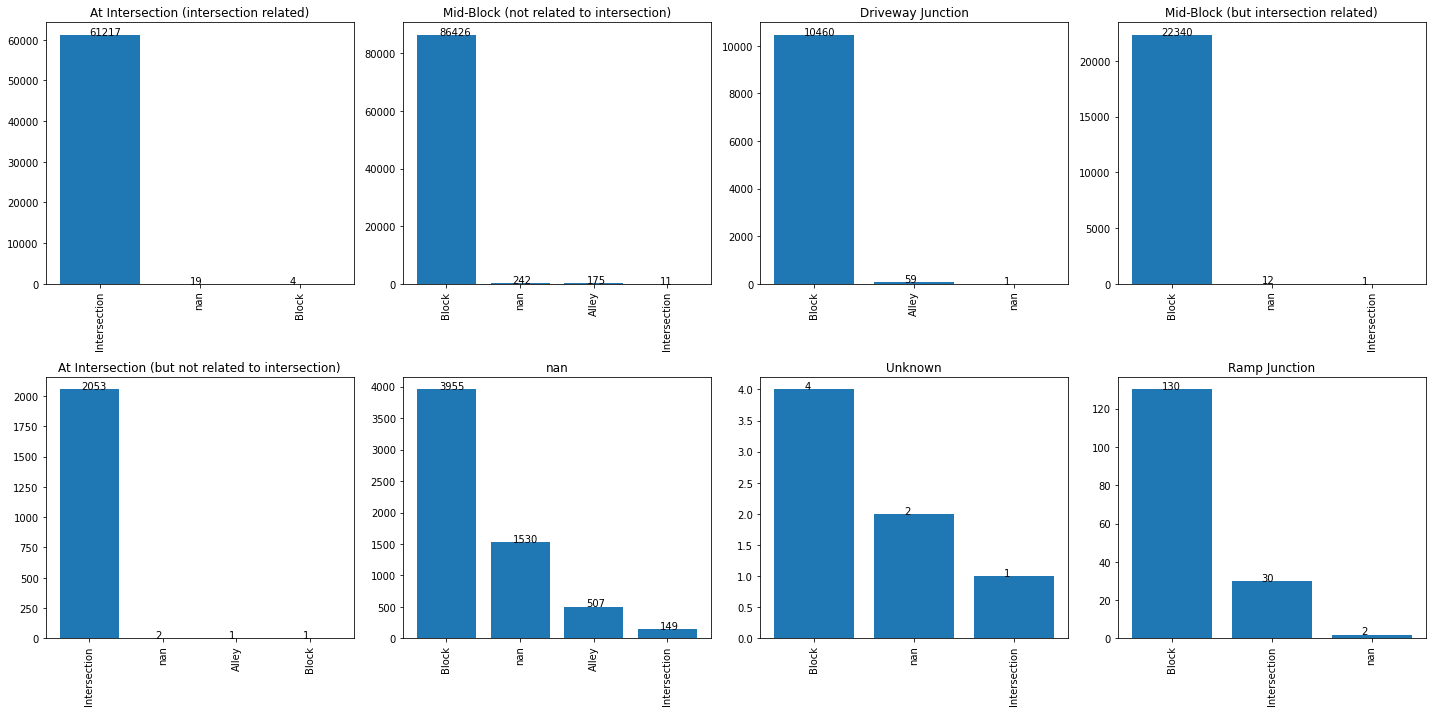

In [29]:
# plot distribution of ADDRTYPE values according to the different JUNCTIONTYPE values
bar_plot(df1, 'junctiontype', 'addrtype', no_col=4)

A number of null *addrtype* value corresponded to null *junctiontype* values (1,530). These entries will be dropped as they are unable to provide much value.

A large number of null values exist in the *junctiontype* feature, and a large proprotion of these entries contain *addrtype* feature with Block value (3,955 out of 4,611).

For the remaining nan values, they will be relabelled as unknown.

In [30]:
# drop rows when null values are present in both junctiontype and addrtype
df1.dropna(subset=['junctiontype', 'addrtype'], how='all', inplace=True)

In [31]:
# relabel remaining nan values as 'unknown'
df1[['junctiontype', 'addrtype']] = df1[['junctiontype', 'addrtype']].fillna('Unknown')

In [32]:
print(df1['addrtype'].value_counts(dropna=False))
print(df1['junctiontype'].value_counts(dropna=False))

Block           123320
Intersection     63462
Alley              742
Unknown            280
Name: addrtype, dtype: int64
Mid-Block (not related to intersection)              86854
At Intersection (intersection related)               61240
Mid-Block (but intersection related)                 22353
Driveway Junction                                    10520
Unknown                                               4618
At Intersection (but not related to intersection)     2057
Ramp Junction                                          162
Name: junctiontype, dtype: int64


In [33]:
df1.isna().sum()

addrtype            0
severitycode        0
personcount         0
pedcount            0
pedcylcount         0
vehcount            0
junctiontype        0
weather             0
roadcond            0
lightcond           0
seglanekey          0
crosswalkkey        0
hitparkedcar        0
date                0
time            25452
dtype: int64

There is still a significant amount of entries with no time information. However, we will keep them for further analysis and consider pairwise deletion strategy.

## Exploratory Data Analysis

In this section, the data will be explored and analysed to obtain a better understanding of the data's main characteristics and also to uncover important relationships between the different features.

### Target Variable: Severity

The main target variable in this case is severity, represented by the feature column *severitycode*.

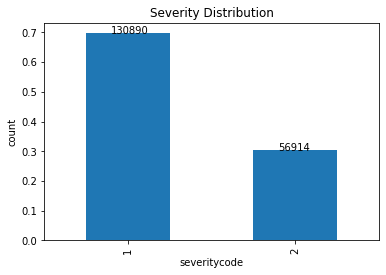

In [34]:
# plot the distribution of severitycode
data = df1['severitycode'].value_counts(normalize=True)
data.plot(kind='bar')

plt.xlabel('severitycode')
plt.ylabel('count')
plt.title('Severity Distribution')

# add data labels corresponding to the actual counts
for x, y in data.items():
    plt.text(x-1.1, y, str(df1['severitycode'].value_counts()[x]))
    
plt.show()

The data is imbalanced, with the proportion of the minority class corresponding to *severitycode* of 1 at about 30%. While this may be the naturally occurring distribution of incident severity, down-sampling of the majority class or up-sampling of the minority class can be considered as strategies to improve the performance of the model. However, as a start, the model will be built upon the true distribution 

We will also relabel *severitycode* values (1, 2) to (0, 1) for sake of convention, with 0 corresponding to property damage only and 1 corresponding to cases involving injuries.

In [35]:
# replace severitycode values (1,2) to (0, 1)
df1['severitycode'].replace(1, 0, inplace=True)
df1['severitycode'].replace(2, 1, inplace=True)

### Seasonality

We start by exploring seasonality patterns of the number of incidents and the variation in severitycode.

In [36]:
# create new dataframe copy consisting of severity and date columns
df_season = df1[['date', 'time','severitycode']]
df_season.head()

,date,time,severitycode
0,2013-03-27,2013-03-27 14:54:00,1
1,2006-12-20,2006-12-20 18:55:00,0
2,2004-11-18,2004-11-18 10:20:00,0
3,2013-03-29,2013-03-29 09:26:00,0
4,2004-01-28,2004-01-28 08:04:00,1


In [37]:
# find number of incidences per date entry
df_season_daily = df_season.groupby(['date'])['severitycode'].count()
df_season_daily

date
2004-01-01    25
2004-01-02    64
2004-01-03    20
2004-01-04    14
2004-01-05    18
              ..
2020-04-25     2
2020-04-26     1
2020-04-27     2
2020-04-28     1
2020-04-29     1
Name: severitycode, Length: 5948, dtype: int64

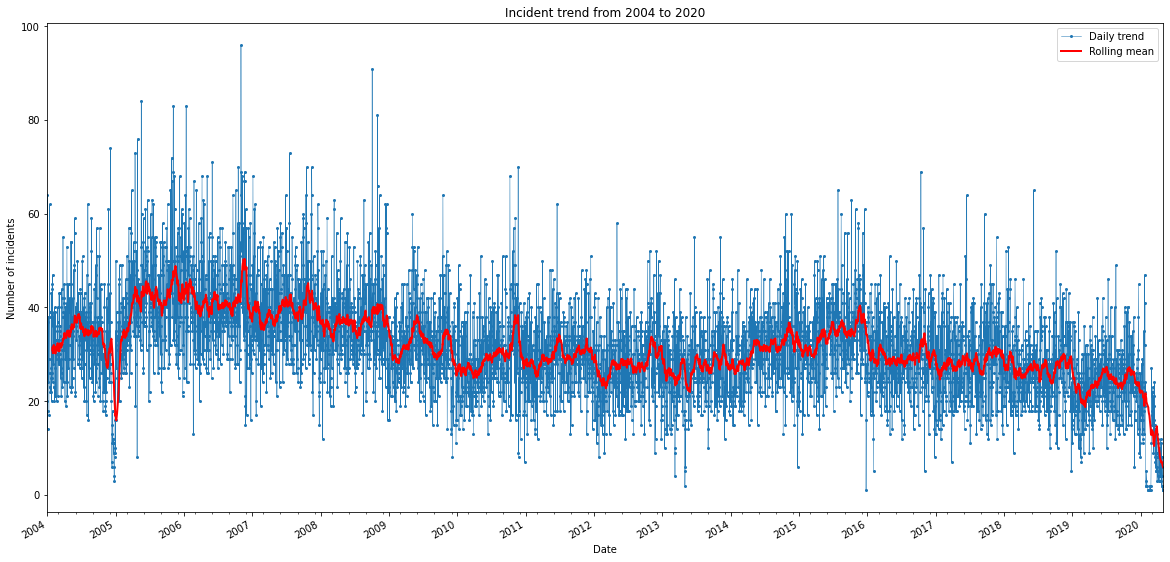

In [38]:
fig,ax = plt.subplots()

# plot daily trend of total accidents
df_season_daily.plot(figsize=(20,10), marker='o', markersize=2, linewidth=0.5, label='Daily trend', ax=ax, x_compat=True)

# find rolling mean, 30 days for general trend. shift(-15) to bring results 15 days backwards, 1st 15 dates have nan values
df_season_daily_rolling = df_season_daily.rolling(30).mean()
df_season_daily_rolling.plot(color='r', linewidth=2, label='Rolling mean')

# setting yearly xticks
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

# setting quaterly minor xticks
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Number of incidents')
plt.title('Incident trend from 2004 to 2020')
plt.legend()

plt.show()

From the above, it is not very clear if there is a seasonal trend to the incident occurence. In general, there seems to be 2 peaks of incident occurence, somewhere during mid-year and end-year, which coincides with the holiday periods.

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


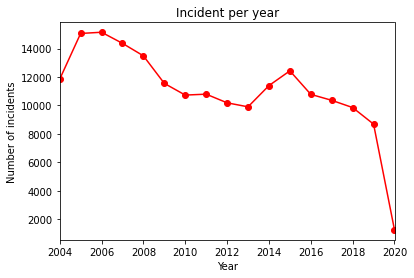

In [39]:
# By year

df_season['year'] = df_season['date'].dt.year
df_season.groupby(['year'])['severitycode'].count().plot(marker='o', color='r', label='Total')

plt.xlabel('Year')
plt.ylabel('Number of incidents')
plt.title('Incident per year')

plt.show()

Looking at the total incidents yearly from 2004 to 2020, with the exception of 2014 to 2015, there is a general decreasing trend of incident occurence which is encouraging.

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


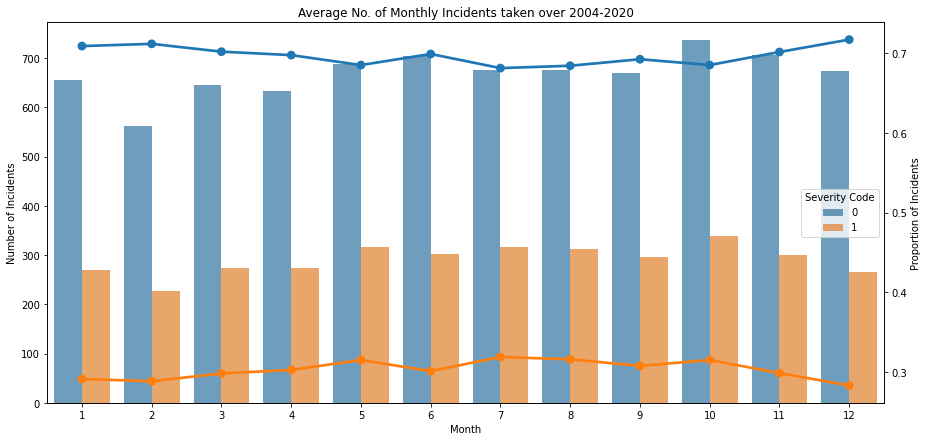

In [40]:
# By month

# create month values
df_season['month'] = df_season['date'].dt.month

# create df_season_monthly which shows the avg incident counts taken over 2004-2020 according to the months, broken down into severitycode of 1 and 0
df_season_monthly = df_season.groupby(['month','severitycode'])['year'].value_counts().to_frame('counts').reset_index()
df_season_monthly  = df_season_monthly .groupby(['month', 'severitycode'])['counts'].mean().to_frame('counts').reset_index()

# create addition counts_proportion column that calculates the proportion of severity code 1 vs 0
counts_proportion = []
for month, total in (df_season_monthly.groupby(['month'])['counts'].sum()).items():
    counts_proportion.extend((df_season_monthly.loc[df_season_monthly['month'] == month, 'counts']/total).tolist())
df_season_monthly = df_season_monthly.assign(counts_proportion=counts_proportion)

# set up subplot axes
fig, ax1 = plt.subplots(figsize=(15,7))
# plot barchart
sns.barplot(data=df_season_monthly, x='month', y='counts', hue='severitycode', alpha=0.7, ax=ax1)
# bar chart labels
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Average No. of Monthly Incidents taken over 2004-2020')
ax1.legend(loc='center right', title='Severity Code')

# create axes for 2ndplot, sharing same x-axis
ax2 = ax1.twinx()
# plot pointplot
sns.pointplot(data=df_season_monthly, x='month', y='counts_proportion', marker='o', hue='severitycode', ax=ax2)
# chart labels
ax2.set_ylabel('Proportion of Incidents')
ax2.legend_.remove()


plt.show()

Looking at the average number of monthly incidents taken over 2004-2020 showed that there are indeed 2 peak periods of incidents, one about May-June period and the other around October-November. Expectedly, the number of serious incidents (severitycode 1) are lower than that of non-serious incidents. The proportion of incidents however seem stable across the months, with incidents of severity code 1 hovering approximately 28-30% of the total incidents. We would include a month feature for further analysis.

We then look into the daily patterns:

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


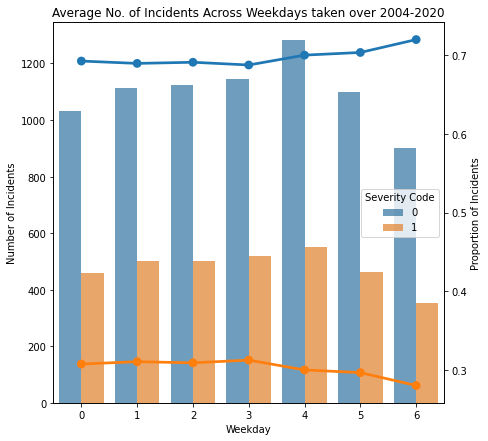

In [41]:
# By weekday

# create weekday values
df_season['day'] = df_season['date'].dt.dayofweek

# create df_season_weekday which shows the avg incident counts taken over 2004-2020 according to the weekdays, broken down into severitycode of 1 and 0
df_season_day = df_season.groupby(['day','severitycode'])['year'].value_counts().to_frame('counts').reset_index()
df_season_day  = df_season_day.groupby(['day', 'severitycode'])['counts'].mean().to_frame('counts').reset_index()

# create addition counts_proportion column that calculates the proportion of severity code 1 vs 0
counts_proportion = []
for day, total in (df_season_day.groupby(['day'])['counts'].sum()).items():
    counts_proportion.extend((df_season_day.loc[df_season_day['day'] == day, 'counts']/total).tolist())
df_season_day = df_season_day.assign(counts_proportion=counts_proportion)


fig, ax1 = plt.subplots(figsize=(7,7))
sns.barplot(data=df_season_day, x='day', y='counts', hue='severitycode', alpha=0.7, ax=ax1)

ax1.set_xlabel('Weekday')
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Average No. of Incidents Across Weekdays taken over 2004-2020')
ax1.legend(loc='center right', title='Severity Code')


# create axes for 2ndplot, sharing same x-axis
ax2 = ax1.twinx()
# plot pointplot
sns.pointplot(data=df_season_day, x='day', y='counts_proportion', marker='o', hue='severitycode', ax=ax2)
# chart labels
ax2.set_ylabel('Proportion of Incidents')
ax2.legend_.remove()

plt.show()

Looking at the weekday incident pattern, we see that on average, there are more incident occurrences on Fridays (the end of the work week), and a considerably lower occurrence on Sundays.

The above also shows that there is a decreasing proportion of severe incidents as we head into the weekends, but the change is small (31% - 28%). We would include a day feature for further analysis.

Next we look at the hourly patterns.

C:\Users\marti\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


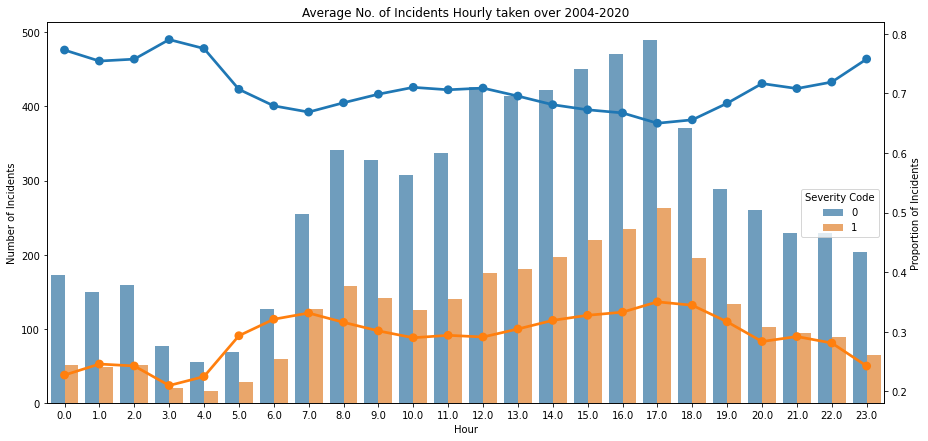

In [42]:
# By hour

# create hour values
df_season['hour'] = df_season['time'].dt.hour

# create df_season_hourly which shows the avg incident counts taken over 2004-2020 according to the hour, broken down into severitycode of 1 and 0
df_season_hourly = df_season.groupby(['hour','severitycode'])['year'].value_counts().to_frame('counts').reset_index()
df_season_hourly  = df_season_hourly.groupby(['hour', 'severitycode'])['counts'].mean().to_frame('counts').reset_index()

# create addition counts_proportion column that calculates the proportion of severity code 1 vs 0
counts_proportion = []
for hour, total in (df_season_hourly .groupby(['hour'])['counts'].sum()).items():
    counts_proportion.extend((df_season_hourly .loc[df_season_hourly ['hour'] == hour, 'counts']/total).tolist())
df_season_hourly  = df_season_hourly .assign(counts_proportion=counts_proportion)


fig, ax1 = plt.subplots(figsize=(15,7))
sns.barplot(data=df_season_hourly, x='hour', y='counts', hue='severitycode', alpha=0.7, ax=ax1)

ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Average No. of Incidents Hourly taken over 2004-2020')
ax1.legend(loc='center right', title='Severity Code')


# create axes for 2ndplot, sharing same x-axis
ax2 = ax1.twinx()
# plot pointplot
sns.pointplot(data=df_season_hourly, x='hour', y='counts_proportion', marker='o', hue='severitycode', ax=ax2)
# chart labels
ax2.set_ylabel('Proportion of Incidents')
ax2.legend_.remove()

plt.show()

The above hourly analysis drops entries with null values in the time columns, but computes from the rest. Based on the chart, we see that there are two distinct peak periods, one about 8 am when people are going to work and the other at about 5 pm when people are returning from work.

The proportion of incidents happening seems to be strongly affected by the hour, peaking at 35% at 5pm from a low of 21% at 3am. We will include the hour feature for further analysis.

Given that we want to include the hour feature, we would have to deal with entries with null time/hour values. First we look into the distribution of severitycode of the entries with null time/hour values.

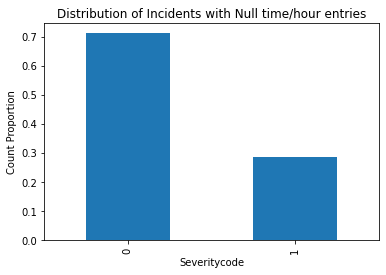

In [43]:
df_season[df_season['hour'].isna()]['severitycode'].value_counts(normalize=True).plot(kind='bar')

plt.xlabel('Severitycode')
plt.ylabel('Count Proportion')
plt.title('Distribution of Incidents with Null time/hour entries')

plt.show()

Given that the proportion of *severitycode* seem very similar to that of the original distribution, we may remove entries with null time/hour value as the true distribution will stil be preserved.

In [44]:
# create hour, month, weekday columns, thereafter, drop entries with null time/hour values and drop date and time columns from df1

df1['hour'] = df_season['time'].dt.hour
df1['day'] = df_season['date'].dt.dayofweek
df1['month'] = df_season['date'].dt.month

df1 = df1.dropna(subset=['hour'])
df1 = df1.drop(columns=['date', 'time'])

### Location

In this section we explore the location based features (*junctiontype, addrtype, seglanekey, crosswalkkey*) and how their relationship with the incident *severitycode*.

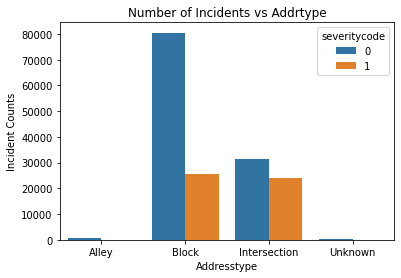

In [45]:
# by addrtype
data = df1.groupby(['addrtype'])['severitycode'].value_counts().to_frame('counts').reset_index()

sns.barplot(data=data, x='addrtype', y='counts', hue='severitycode')

plt.xlabel('Addresstype')
plt.ylabel('Incident Counts')
plt.title('Number of Incidents vs Addrtype')

plt.show()

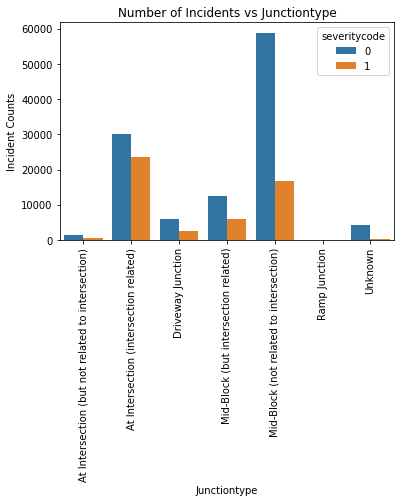

In [46]:
# by junctiontype
data = df1.groupby(['junctiontype'])['severitycode'].value_counts().to_frame('counts').reset_index()

sns.barplot(data=data, x='junctiontype', y='counts', hue='severitycode')

plt.xticks(rotation=90)
plt.xlabel('Junctiontype')
plt.ylabel('Incident Counts')
plt.title('Number of Incidents vs Junctiontype')

plt.show()

We see that there is a huge change in the proportion of incident severity according to the different *junctiontype* and *addrtype* values. As these are also categorical features we will encode them via labelencoder to explore the correlation between these features.

In [47]:
# use labelecnoder from sklearn
le = LabelEncoder()

df1['junction'] = le.fit_transform(df1['junctiontype'])
df1['addr'] = le.fit_transform(df1['addrtype'])

In [48]:
# explore seglanekey and crosswalkkey, hitparkedcar, junction and addr

# assign non-zero seglanekeys and crosswalkkeys as 1
df1.loc[df1['seglanekey'] != 0, ['seglanekey']] = 1
df1.loc[df1['crosswalkkey'] != 0, ['crosswalkkey']] = 1

# replace (Y, N) in hitparkedcar with (1, 0)
df1['hitparkedcar'].replace('Y', 1, inplace=True)
df1['hitparkedcar'].replace('N', 0, inplace=True)

df1.tail(3)

,addrtype,severitycode,personcount,pedcount,pedcylcount,vehcount,junctiontype,weather,roadcond,lightcond,seglanekey,crosswalkkey,hitparkedcar,hour,day,month,junction,addr
194670,Intersection,1,3,0,0,2,At Intersection (intersection related),Clear,Dry,Daylight,0,0,0,9.0,5,1,1,2
194671,Intersection,1,2,0,1,1,At Intersection (intersection related),Clear,Dry,Dusk,1,0,0,16.0,1,1,1,2
194672,Block,0,2,0,0,2,Mid-Block (not related to intersection),Clear,Wet,Daylight,0,0,0,15.0,4,11,4,1


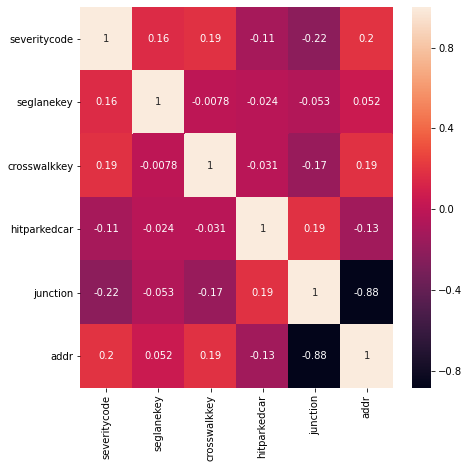

In [49]:
# check correlation of the features
plt.figure(figsize=(7,7))

sns.heatmap(df1[['severitycode', 'seglanekey', 'crosswalkkey', 'hitparkedcar', 'junction', 'addr']].corr(), annot=True)

plt.show()

We see that there are mild correlations between *severitycode* and these features. However, we see that there is a strong correlation between junction and addr. In such a case, it is recommended to drop one feature (addr in this case) to reduce multicollinearity and skewed results, given that the information provided by *addrtype* is also captured by the *junctiontype*. We will then keep the other features *junctiontype, seglanekey, crosswalkkey, hitparkedcar*.

In [50]:
df1.drop(columns=['addr', 'addrtype'], inplace=True)
df1.head()

,severitycode,personcount,pedcount,pedcylcount,vehcount,junctiontype,weather,roadcond,lightcond,seglanekey,crosswalkkey,hitparkedcar,hour,day,month,junction
0,1,2,0,0,2,At Intersection (intersection related),Overcast,Wet,Daylight,0,0,0,14.0,2,3,1
1,0,2,0,0,2,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,0,0,0,18.0,2,12,4
2,0,4,0,0,3,Mid-Block (not related to intersection),Overcast,Dry,Daylight,0,0,0,10.0,3,11,4
3,0,3,0,0,3,Mid-Block (not related to intersection),Clear,Dry,Daylight,0,0,0,9.0,4,3,4
4,1,2,0,0,2,At Intersection (intersection related),Raining,Wet,Daylight,0,0,0,8.0,2,1,1


### Weather, Road and Light Conditions

In this section we explore the weather, light and road based features (*weather, lightcond, roadcond*) and how their relationship with the incident severity.

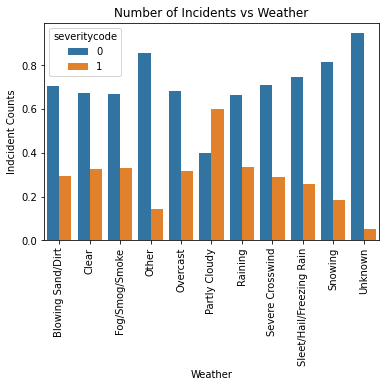

In [51]:
# Weather
data = df1.groupby(['weather'])['severitycode'].value_counts(normalize=True).to_frame('counts').reset_index()

sns.barplot(data=data, x='weather', y='counts', hue='severitycode')

plt.xticks(rotation=90)
plt.xlabel('Weather')
plt.ylabel('Indcident Counts')
plt.title('Number of Incidents vs Weather')

plt.show()

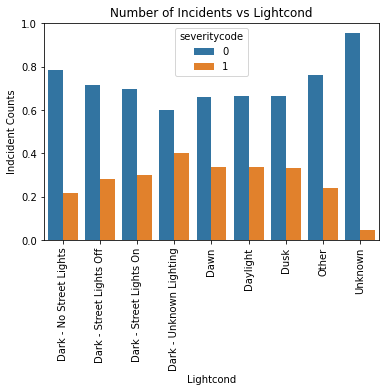

In [52]:
# LightCond
data = df1.groupby(['lightcond'])['severitycode'].value_counts(normalize=True).to_frame('counts').reset_index()

sns.barplot(data=data, x='lightcond', y='counts', hue='severitycode')

plt.xticks(rotation=90)
plt.xlabel('Lightcond')
plt.ylabel('Indcident Counts')
plt.title('Number of Incidents vs Lightcond')

plt.show()

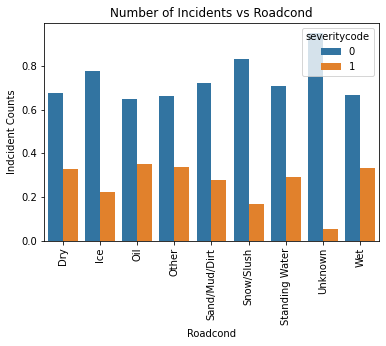

In [53]:
# roadCond
data = df1.groupby(['roadcond'])['severitycode'].value_counts(normalize=True).to_frame('counts').reset_index()

sns.barplot(data=data, x='roadcond', y='counts', hue='severitycode')

plt.xticks(rotation=90)
plt.xlabel('Roadcond')
plt.ylabel('Indcident Counts')
plt.title('Number of Incidents vs Roadcond')

plt.show()

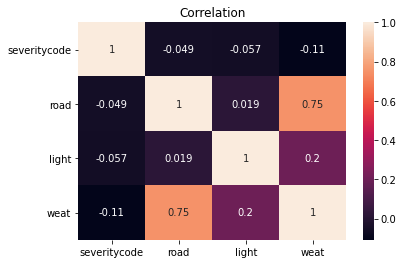

In [54]:
# explore correlation

# encode lightcond, weather, roadcond
le = LabelEncoder()

df1['road'] = le.fit_transform(df1['roadcond'])
df1['light'] = le.fit_transform(df1['lightcond'])
df1['weat'] = le.fit_transform(df1['weather'])

sns.heatmap(df1[['severitycode','road', 'light', 'weat']].corr(), annot=True)

plt.title('Correlation')

plt.show()

We observe that there is some correlation between the severity code and the *weather, lightcond, roadcond*, with the weather having the greater correlation to *severitycode*. What we also observe is the strong correlation between the *weather* and the *roadcond*, which is to be expected, as ice and snow on the road can only be present when the weather freezing rain/snowing.

Ideally, we would remove either *weather* or *roadcond*. However, we see that there are certain *roadcond* values such as Oil and Unknown which are not represented by a corresponding *weather* value. As such, we will keep these features for now.

### Others

We explore the remaining features *personcount, pedcount, pedcylcount, vehcount*. We expect that these will show strong correlation with *severitycode*, as generally, with more people or vehicle involved in the accident, the more likely it is that there will be a serious injury.

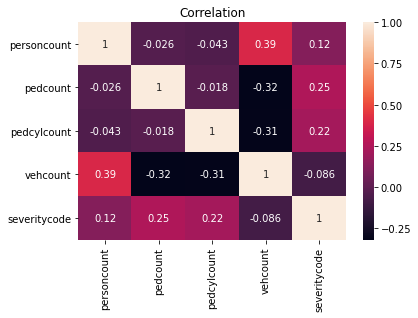

In [55]:
# check correlation between these features

sns.heatmap(df1[['personcount', 'pedcount', 'pedcylcount', 'vehcount', 'severitycode']].corr(), annot=True)

plt.title('Correlation')

plt.show()

What we observe expectedly, is the strong correlation between these 4 factors. We also see that the severitycode is less correlated to the vehicle count but most correlated to the pedestrian count. This is understandable as the *severitycode* is based on the presence of personnel injury, which has a higher change of occurring if a pedestrian or pedalcyclist (with minimal protection as compared to those in vehicles) is involved.

## Data Preparation

Before building the model, the categorical features in the dataset will be encoded so that they can be used to build the model. Also, non-useful features will be dropped. Thereafter, the dataset will be split into train and test set, before they are individually scaled. By scaling after the train_test dataset split, target leakage is avoided.

### Categorical Encoding
One-hot encoding is used as the categorical features have no ordinal relationship existing.

In [56]:
# use pandas get_dummies to create one-hot encoding
df1_enc = pd.get_dummies(df1)

In [57]:
# create dataframe X containg the relevant perdictor features and y containing the target feature
features_drop = ['severitycode','junction', 'road', 'light', 'weat']

X = df1_enc.drop(columns=features_drop)

y = df1_enc['severitycode']

### Train-Test Split

In [58]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((129881, 46), (32471, 46), (129881,), (32471,))

### Normalisation

In [59]:
# create sc instance
sc = StandardScaler()

# fit_transform X_train dataset
X_tr_sc = sc.fit_transform(X_train)
X_tr_sc = pd.DataFrame(X_tr_sc, index=X_train.index, columns=X_train.columns)

# transform X_test dataset
X_te_sc = sc.transform(X_test)
X_te_sc = pd.DataFrame(X_te_sc, index=X_test.index, columns=X_test.columns)

In [60]:
X_tr_sc.head(3)

,personcount,pedcount,pedcylcount,vehcount,seglanekey,crosswalkkey,hitparkedcar,hour,day,month,...,roadcond_Wet,lightcond_Dark - No Street Lights,lightcond_Dark - Street Lights Off,lightcond_Dark - Street Lights On,lightcond_Dark - Unknown Lighting,lightcond_Dawn,lightcond_Daylight,lightcond_Dusk,lightcond_Other,lightcond_Unknown
147981,-0.335782,-0.192608,-0.176573,0.056120,-0.126102,-0.148273,4.866982,-1.105499,-1.010174,0.713239,...,-0.579825,-0.090625,-0.079709,-0.588574,-0.007848,-0.115266,-1.271214,-0.176643,-0.032966,3.761884
135497,-0.335782,-0.192608,-0.176573,0.056120,-0.126102,-0.148273,-0.205466,-0.751001,1.069293,1.588602,...,-0.579825,-0.090625,-0.079709,-0.588574,-0.007848,-0.115266,-1.271214,-0.176643,-0.032966,3.761884
194593,1.863052,-0.192608,-0.176573,1.841309,-0.126102,-0.148273,-0.205466,0.135243,-1.530041,1.588602,...,-0.579825,-0.090625,-0.079709,-0.588574,-0.007848,-0.115266,0.786650,-0.176643,-0.032966,-0.265824


## Model Building

### Logistic Regression

Basic binary classification model can be build based on logistic regression.

In [61]:
# create model
lr1 = LogisticRegression()

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(lr1, X_tr_sc, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.357 (0.009)


In [62]:
# fit model
lr1.fit(X_tr_sc, y_train)

# predict using X_te_sc and score using classification report
yhat = lr1.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.74      0.98      0.84     22582
           1       0.81      0.23      0.36      9889

    accuracy                           0.75     32471
   macro avg       0.78      0.60      0.60     32471
weighted avg       0.76      0.75      0.70     32471



### Random Tree Classifier

As Logistic Regression resulted in a rather poor F1-score, we would try an ensemble decision tree method, the Random Forest which uses a number of Decision Tree classifiers to improve the predictive accuracy and control over-fitting.

In [63]:
# create model
rf1 = RandomForestClassifier(criterion='entropy')

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(rf1, X_tr_sc, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.451 (0.007)


In [64]:
# fit model
rf1.fit(X_tr_sc, y_train)

# predict using X_te_sc and score using classification report
yhat = rf1.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.85      0.80     22582
           1       0.53      0.39      0.45      9889

    accuracy                           0.71     32471
   macro avg       0.65      0.62      0.63     32471
weighted avg       0.69      0.71      0.70     32471



### Gradient Boosting Classifier

Given that we see an improvement in the performance of the Random Tree model, we would also try a Gradient Boosting Classifier model, which is also based on decision trees. The goal is to improve the precision and recall of predicting the positive outcome, i.e. severitycode = 1.

In [65]:
# create model
gbc1 = GradientBoostingClassifier()

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(gbc1, X_tr_sc, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.380 (0.010)


In [66]:
# fit model
gbc1.fit(X_tr_sc, y_train)

# predict using X_te_sc and score using classification report
yhat = gbc1.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     22582
           1       0.80      0.25      0.38      9889

    accuracy                           0.75     32471
   macro avg       0.77      0.61      0.61     32471
weighted avg       0.76      0.75      0.70     32471



In [67]:
# printing score table
scores = {}
models = [lr1, rf1, gbc1]

for model in models:
    yhat = model.predict(X_te_sc)
    jaccard = jaccard_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    precision = precision_score(y_test, yhat, average='weighted')
    recall = recall_score(y_test, yhat)

    score = [jaccard, f1, precision, recall]
    scores[type(model).__name__] = score

scores = pd.DataFrame.from_dict(scores, orient='index', columns=['Jaccard', 'F1-Score', 'Precision', 'Recall'])

scores

,Jaccard,F1-Score,Precision,Recall
LogisticRegression,0.217925,0.695961,0.763623,0.229649
RandomForestClassifier,0.293388,0.696573,0.692283,0.394883
GradientBoostingClassifier,0.233568,0.703156,0.763548,0.247952


The above showed that the Gradient Boosting model shows a general improvement over the Random Forest model, largely due to the improvements in predictive precision. However, it has a worse recall than the Random Forest. Its performance is on par with the Logistic Regression Model.

Overall, it still fits poorly, with very poor recall. Recall is True positive/(true positive + false negative), which in our case, is an important metrics as it meant avoiding the situation where the model predicted a severity code of 0 (not serious) when it is 1 (serious).

It is likely that the poor performance is due to the imbalanced dataset. As such we will balance the training dataset, before retraining the models.

### Data Balancing

In [68]:
# training set rebalance

# create instance of undersampler
r=RandomUnderSampler(random_state=42, sampling_strategy=1.0)

# balance normalised dataset X_tr_sc
X_tr_sc_rebal, y_train_rebal = r.fit_resample(X_tr_sc, y_train)

After balancing the train dataset, train and evaluate model again.

In [69]:
X_tr_sc_rebal.shape, X_tr_sc.shape

((79418, 46), (129881, 46))

### Retrain LR, GBC and RF Models

In [70]:
# create model
lr2 = LogisticRegression()

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(lr2, X_tr_sc_rebal, y_train_rebal, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.656 (0.006)


In [71]:
# fit model
lr2.fit(X_tr_sc_rebal, y_train_rebal)

# predict using X_te_sc and score using classification report
yhat = lr2.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     22582
           1       0.47      0.65      0.55      9889

    accuracy                           0.67     32471
   macro avg       0.64      0.66      0.64     32471
weighted avg       0.71      0.67      0.68     32471



In [72]:
# create model
rf2 = RandomForestClassifier(criterion='entropy')

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(rf2, X_tr_sc_rebal, y_train_rebal, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.633 (0.004)


In [73]:
# fit model
rf2.fit(X_tr_sc_rebal, y_train_rebal)

# predict using X_te_sc and score using classification report
yhat = rf2.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.64      0.71     22582
           1       0.43      0.63      0.51      9889

    accuracy                           0.64     32471
   macro avg       0.62      0.64      0.61     32471
weighted avg       0.69      0.64      0.65     32471



In [74]:
# create model
gbc2 = GradientBoostingClassifier()

# create kfold instance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# evaluation using F1 score, which is gives a better evaluation of the model given that the data is imbalanced 
n_scores = cross_val_score(gbc2, X_tr_sc_rebal, y_train_rebal, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.670 (0.006)


In [75]:
# fit model
gbc2.fit(X_tr_sc_rebal, y_train_rebal)

# predict using X_te_sc and score using classification report
yhat = gbc2.predict(X_te_sc)
cr = metrics.classification_report(y_test,yhat)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.64      0.73     22582
           1       0.46      0.70      0.56      9889

    accuracy                           0.66     32471
   macro avg       0.65      0.67      0.64     32471
weighted avg       0.72      0.66      0.67     32471



# Conclusion

We see an improvement in performance of all models after rebalancing the training dataset. With a balanced dataset, the GBC model has improved and performed better in all aspects than the RF model, with the LR model close in predictive performance.

In this current situation, recall is the more important evaluation metrics than precision as a higher recall will minimise the situation of False Negatives, i.e. predicting an incident to have lower severity when in reality, it is severe. 

Overall, we see that GBC returns the best performance compared to LR and RF, boasting a recall of 0.70 vs 0.64 and 0.63 from LR and RF respectively. The poor Jaccard score for all models however meant that the models tend to fail in predicting a large portion of the dataset correctly.

A closer look into the classification reports above show that most model suffer from poor precision for the severe case, i.e. when *severitycode* == 1, i.e. there is a tendency for the model to make False Positives.

To further improve prediction of the models, hyperparameter tuning of the models can be carried out. However, to further greatly improve the scores, it is highly likely that we may have to look deeper into feature or data engineering to obtain better predictive features.

In [76]:
# printing score table
scores = {}
models = [lr2, rf2, gbc2]

for model in models:
    yhat = model.predict(X_te_sc)
    jaccard = jaccard_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='weighted')
    precision = precision_score(y_test, yhat, average='weighted')
    recall = recall_score(y_test, yhat)

    score = [jaccard, f1, precision, recall]
    scores[type(model).__name__] = score

scores = pd.DataFrame.from_dict(scores, orient='index', columns=['Jaccard', 'F1-Score', 'Precision', 'Recall'])

scores

,Jaccard,F1-Score,Precision,Recall
LogisticRegression,0.374934,0.683458,0.710611,0.645262
RandomForestClassifier,0.346542,0.650458,0.687633,0.632319
GradientBoostingClassifier,0.387755,0.674996,0.719825,0.703206


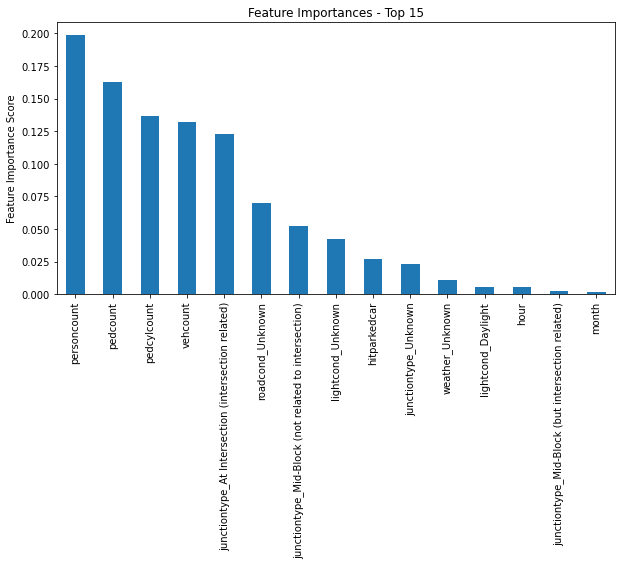

In [77]:
# plot feature importance
plt.figure(figsize=(10,5))
feat_imp = pd.Series(gbc2.feature_importances_, X_tr_sc_rebal.columns).sort_values(ascending=False)[:15]
feat_imp.plot(kind='bar', title='Feature Importances - Top 15')
plt.ylabel('Feature Importance Score')

plt.show()

We also see that based on feature importance, there are only a few main features which contributes largely to the model predictions, namely, *personcount, pedcount, pedcylcount, vehcount* and *juntiontype*. It is also interesting to see that unknown *roadcond, lightcond and junctiontype* conditions contribute largely to the prediction.

It is no surprise that the number people, vehicle involved in the incident could be a predictor of the *severitycode*. This insight provides little value and as such, we may consider removing them from future analysis.

A further look into entries with unknown values in the *roadcond, lightcond,junctiontype* should also be carried out to understand why these values are unknown, given the relative importance they are in prediction.